In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from functools import reduce
from scipy.stats import entropy
import glob
import sys
sys.path.append('../')
from package_global_functions import *

def get_avg_traj_kbs(dfs):
    for df in dfs:
        df['sum'] = df['R'] + df['G'] + df['B']
        df['f2'] = df['B']/df['sum']
        df['f1'] = df['G']/df['sum']
        df['f0'] = df['R']/df['sum']
        df['count'] = [1,]*len(df)
        df = df.drop(labels=['file', 'R', 'G', 'B', 'correct', 'sum'], axis=1, inplace=True)
    df_avg = reduce(lambda a,b: a.add(b, fill_value=0), dfs)
    # df_avg = df_avg/len(dfs)
    for c in df_avg.columns:
        df_avg[c] = df_avg[c]/df_avg['count']
    return df_avg

path_kb_data = '../../kilobot_experiments_data/BeesModel_N=35_ordered'

### Read, avg  and plot some evolutions:

In [ ]:
filep1 = 'BeesModel_N=35_deltat=0800_f0static_p1=30_p2=30_q1=07_q2=10_lambda=00_rep=01-results.csv'
df1 = pd.read_csv(f'{path_kb_data}/{filep1}')
filep2 = 'BeesModel_N=35_deltat=0800_f0static_p1=30_p2=30_q1=07_q2=10_lambda=00_rep=02-results.csv'
df2 = pd.read_csv(f'{path_kb_data}/{filep2}')

# for df in [df1, df2]:
#     df['sum'] = df['R'] + df['G'] + df['B']
#     df['f2'] = df['B']/df['sum']
#     df['f1'] = df['G']/df['sum']
#     df['f0'] = df['R']/df['sum']
#     df = df.drop(labels=['file', 'R', 'G', 'B', 'correct', 'sum'], axis=1, inplace=True)

dfavg = get_avg_traj_kbs([df1, df2])
print(len(df1), len(df2), len(dfavg))
fig, ax = plt.subplots()
cicles = np.arange(1,len(df1)+1,1)
ax.plot(range(len(df1)), df1['f2'], lw=0.8, color='xkcd:blue')
ax.plot(range(len(df2)), df2['f2'], lw=0.8, color='xkcd:blue', ls=':')
ax.plot(range(len(dfavg)), dfavg['f2'], lw=0.8, color='xkcd:blue', ls='--')

### Identify files and save to a dataframe

In [102]:
files = glob.glob(f'{path_kb_data}/*.csv')

ls = []
pi1s = []
pi2s = []

for file in files:
    pi1int = int(file.split('_')[8].split('=')[1])
    pi2int = int(file.split('_')[9].split('=')[1])
    lint = int(file.split('_')[12].split('=')[1])
    # print(pi1int, pi2int, lint)  
    pi1s.append(pi1int), pi2s.append(pi2int), ls.append(lint)

df = pd.DataFrame({'file':files, 'lamb':ls, 'pi1':pi1s, 'pi2':pi2s})

df.to_csv('files_kb_N_35.csv', index=False)

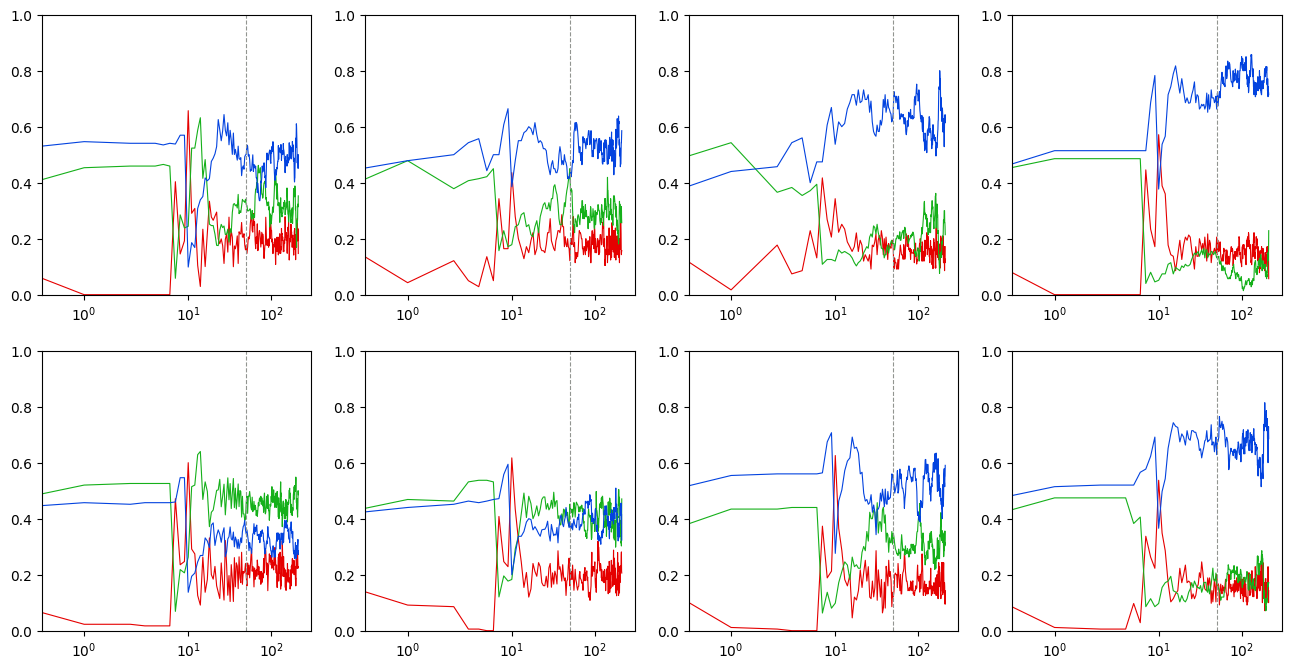

In [59]:
fig, ax = plt.subplots(2,4, figsize=(16,8))

dffiles = pd.read_csv('files_kb_N_35.csv')

for i,pi_pair in enumerate([(30, 30), (40, 20)]):
    pi1, pi2 = pi_pair
    for j,l in enumerate([0, 30, 60, 90]):
        dfa = dffiles.query('lamb == @l & pi1 == @pi1 & pi2 == @pi2')
        dfs = [pd.read_csv(f) for f in dfa['file']]
        df_avg = get_avg_traj_kbs(dfs)
        cicles = np.arange(len(df_avg))
        ax[i,j].plot(cicles, df_avg['f0'], lw=0.8, color='xkcd:red')
        ax[i,j].plot(cicles, df_avg['f1'], lw=0.8, color='xkcd:green')
        ax[i,j].plot(cicles, df_avg['f2'], lw=0.8, color='xkcd:blue')
        ax[i,j].set_xscale('symlog')
        ax[i,j].set_ylim(0.0, 1.0)
        ax[i,j].set_xlim(0.08, None)
        ax[i,j].axvline(50, ls='--', lw=0.8, color='xkcd:gray')


In [2]:
pi_pairs = [(30, 30), (40, 20)]
lambs = [0, 30, 60, 90]
# lambs = [0, ]
states_df = {'pi1':[], 'pi2':[], 'lamb':[]} # 'Qavg':[]
states_ids = ['Qf2', 'qf2', 'draw', 'qf1', 'Qf1']
for sid in states_ids:
    states_df[sid] = []

dffiles = pd.read_csv('files_kb_N_35.csv')

for pi_pair in pi_pairs:
    pi1, pi2 = pi_pair
    for l in lambs:
        states = [0, 0, 0, 0, 0] # [f2 > 2*f1, f2 > f1, f2 == f2, f1 > f2, f1 > 2*f2]
        prevsum = 0
        Qavg = 0
        dfa = dffiles.query('lamb == @l & pi1 == @pi1 & pi2 == @pi2')
        for f in dfa['file']:
            dfi = pd.read_csv(f)
            if (len(dfi) < 100):
                print(f)
            dfi['sum'] = dfi['R'] + dfi['G'] + dfi['B']
            dfi['f2'] = dfi['B']/dfi['sum']
            dfi['f1'] = dfi['G']/dfi['sum']
            dfi['f0'] = dfi['R']/dfi['sum']
            dfi['Q'] = dfi['f2'] - 2*dfi['f1']
            dfi = dfi.drop(labels=['file', 'R', 'G', 'B', 'correct', 'sum'], axis=1)
            for row in dfi[50:].itertuples():
                f2, f1 = row[1], row[2]
                if f2 > 2*f1:
                    states[0] += 1
                elif f2 > f1:
                    states[1] += 1
                elif f2 == f1:
                    states[2] += 1
                elif f1 > 2*f2:
                    states[4] += 1
                elif f1 > f2:
                    states[3] += 1
            # if len(dfi[50:]) == (sum(states) - prevsum):
            #     # continue
            #     print('godood')
            # else:
            #     print('errorrrr')
            #     print(len(dfi[50:]), sum(states)-prevsum)
            if not len(dfi[50:]) == (sum(states) - prevsum):
                print('errorrrr')
            prevsum = sum(states)
            # Qavg += np.average(dfi[50:]['Q'])
        # Qavg = Qavg/len(dfa)
        states_df['pi1'].append(pi_pair[0]), states_df['pi2'].append(pi_pair[1]), states_df['lamb'].append(l) #, states_df['Qavg'].append(Qavg)
        for i,sid in enumerate(states_ids):
            states_df[sid].append(states[i])

states_df = pd.DataFrame(states_df)
states_df.to_csv('files_kb_N_35_states.csv', index=False)
    

../../kilobot_experiments_data/BeesModel_N=35_ordered/BeesModel_N=35_deltat=0800_f0static_p1=30_p2=30_q1=07_q2=10_lambda=90_rep=03-results.csv


In [ ]:
labels = ['$f_2 > 2f_1$', '$f_2 > f_1$', '$f_2 = f_1$', '$f_1 > f_2$', '$f_2 > 2 f_1$']
fig, ax = plt.subplots()
ax.pie(states, labels=labels, autopct='%1.1f%%')

### fent servir subplots normal

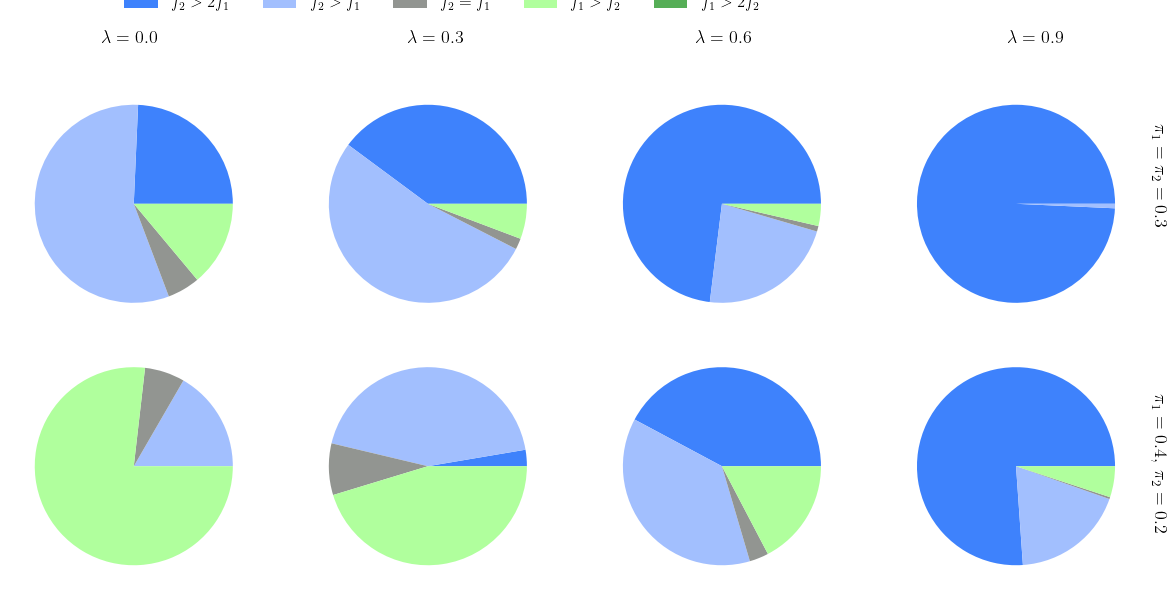

In [12]:
latexFont(titlesize=11, ticklabelssize=11, labelsize=13, legendsize=12)

fig, ax = plt.subplots(2,4, figsize=(12,6))
fig.subplots_adjust(left=0.01, right=0.99, bottom=0.05, top=0.90, hspace=0.06, wspace=0.001)

states_ids = ['Qf2', 'qf2', 'draw', 'qf1', 'Qf1']

labels = ['$f_2 > 2f_1$', '$f_2 > f_1$', '$f_2 = f_1$', '$f_1 > f_2$', '$f_1 > 2 f_2$']
# colors = plt.cm.Pastel1(np.linspace(0, 1, len(labels)))
# colors = plt.cm.plasma(np.linspace(0.1, 0.9, len(labels)))

# colors = ['xkcd:bright blue', 'xkcd:sky blue', 'xkcd:gray', 'xkcd:light green', 'xkcd:emerald green']
colors = ['xkcd:dodger blue', 'xkcd:pastel blue', 'xkcd:gray', 'xkcd:pastel green', 'xkcd:dark pastel green']

df_states = pd.read_csv('files_kb_N_35_states.csv')

for i,pi_pair in enumerate([(30, 30), (40, 20)]):
    pi1, pi2 = pi_pair
    for j,l in enumerate([0, 30, 60, 90]):
        dfa = df_states.query('lamb == @l & pi1 == @pi1 & pi2 == @pi2')
        states = [int(dfa[sid].iloc[0]) for sid in states_ids]
        # ax[i,j].pie(states, labels=labels, colors=colors, autopct='%1.1f%%')
        if i == 0 and j == 0:
            # wedges, text, autotexts = ax[i,j].pie(states, colors=colors, autopct='%1.1f%%')
            wedges, text = ax[i,j].pie(states, colors=colors)
        else:
            ax[i,j].pie(states, colors=colors)
        # if i == 0:
        #     ax[i,j].set_title(f'$\lambda = {l/100}$')

fig.legend(wedges, labels, loc=(0.1, 0.97), ncol=5, frameon=False)
# ax[0,0].text(0.5, 1.0, '$\lambda = 0.0$', transform=ax[0,0].transAxes)
fig.text(0.105, 0.96, '$\lambda = 0.0$', fontsize=13)
fig.text(0.36, 0.96, '$\lambda = 0.3$', fontsize=13)
fig.text(0.60, 0.96, '$\lambda = 0.6$', fontsize=13)
fig.text(0.86, 0.96, '$\lambda = 0.9$', fontsize=13)

fig.text(0.98, 0.66, f'$\pi_1 = \pi_2 = 0.3$', fontsize=13, rotation=270)
fig.text(0.98, 0.15, f'$\pi_1 = 0.4, \; \pi_2 = 0.2$', fontsize=13, rotation=270)

fig.savefig('pie_charts_different_states_kb_N_35_stationary.pdf')

### fent servir subplots adjust

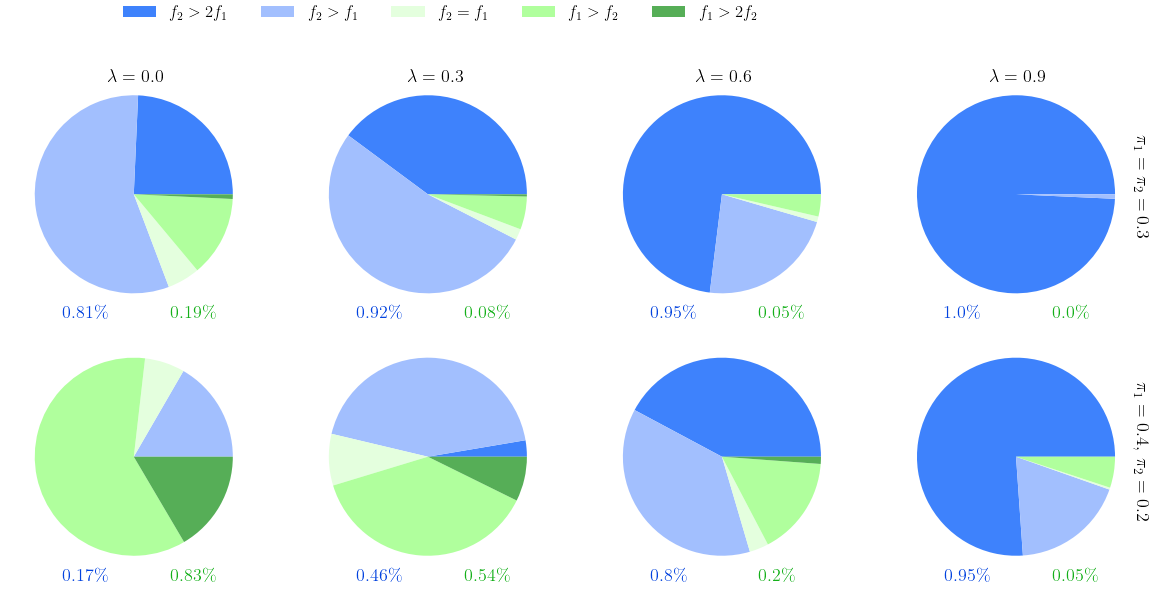

In [3]:
latexFont(titlesize=11, ticklabelssize=11, labelsize=13, legendsize=12)

fig, ax = plt.subplots(2,4, figsize=(12,6))
fig.subplots_adjust(left=0.01, right=0.99, bottom=0.05, top=0.90, hspace=0.06, wspace=0.001)

states_ids = ['Qf2', 'qf2', 'draw', 'qf1', 'Qf1']

labels = ['$f_2 > 2f_1$', '$f_2 > f_1$', '$f_2 = f_1$', '$f_1 > f_2$', '$f_1 > 2 f_2$']
# colors = plt.cm.Pastel1(np.linspace(0, 1, len(labels)))
# colors = plt.cm.plasma(np.linspace(0.1, 0.9, len(labels)))

# colors = ['xkcd:bright blue', 'xkcd:sky blue', 'xkcd:gray', 'xkcd:light green', 'xkcd:emerald green']
colors = ['xkcd:dodger blue', 'xkcd:pastel blue', 'xkcd:gray', 'xkcd:pastel green', 'xkcd:dark pastel green']
colors = ['xkcd:dodger blue', 'xkcd:pastel blue', '#e4ffde', 'xkcd:pastel green', 'xkcd:dark pastel green']

df_states = pd.read_csv('files_kb_N_35_states.csv')

for i,pi_pair in enumerate([(30, 30), (40, 20)]):
    pi1, pi2 = pi_pair
    for j,l in enumerate([0, 30, 60, 90]):
        dfa = df_states.query('lamb == @l & pi1 == @pi1 & pi2 == @pi2')
        states = [int(dfa[sid].iloc[0]) for sid in states_ids]
        # ax[i,j].pie(states, labels=labels, colors=colors, autopct='%1.1f%%')
        if i == 0 and j == 0:
            # wedges, text, autotexts = ax[i,j].pie(states, colors=colors, autopct='%1.1f%%')
            wedges, text = ax[i,j].pie(states, colors=colors)
        else:
            ax[i,j].pie(states, colors=colors)
        # if i == 0:
        #     ax[i,j].set_title(f'$\lambda = {l/100}$')
        posis = ax[i,j].get_position()
        op_choice,sop_choice = (states[0]+states[1])/sum(states), (states[2]+states[3]+states[4])/sum(states)
        fig.text((posis.xmax+posis.xmin)/2-0.06, posis.ymin, f'{round(op_choice,2)}\%', color='xkcd:blue', fontsize=13)
        fig.text((posis.xmax+posis.xmin)/2+0.03, posis.ymin, f'{round(sop_choice,2)}\%', color='xkcd:green', fontsize=13)


fig.legend(wedges, labels, loc=(0.1, 0.954), ncol=5, frameon=False)
# ax[0,0].text(0.5, 1.0, '$\lambda = 0.0$', transform=ax[0,0].transAxes)

height_lambda_labels = 0.88
fig.text(0.11, height_lambda_labels, '$\lambda = 0.0$', fontsize=13)
fig.text(0.36, height_lambda_labels, '$\lambda = 0.3$', fontsize=13)
fig.text(0.60, height_lambda_labels, '$\lambda = 0.6$', fontsize=13)
fig.text(0.845, height_lambda_labels, '$\lambda = 0.9$', fontsize=13)

fig.text(0.965, 0.625, f'$\pi_1 = \pi_2 = 0.3$', fontsize=13, rotation=270)
fig.text(0.965, 0.155, f'$\pi_1 = 0.4, \; \pi_2 = 0.2$', fontsize=13, rotation=270)

fig.savefig('pie_charts_different_states_kb_N_35_stationary.pdf')

In [26]:
ax[1,1].get_position().xmin

0.2743140581457111

# Kullback Liebler Divergence of the histograms

In [39]:
from scipy.special import rel_entr, kl_div

def kl_divergence(p, q):
    return np.sum(np.where(p != 0, p * np.log(p / q), 0))

# def kl_divergence(p, q):
#     return np.sum(np.where(q != 0, p * np.log(p / q), 0))

def kl_div_david(p, q):
    kl = 0
    for pf1,pf2 in zip(p[q > 0], q[q > 0]):
            if pf1 > 0.0:
                kl += pf1*np.log(pf1/pf2)
    return kl

# https://mathoverflow.net/questions/72668/how-to-compute-kl-divergence-when-pmf-contains-0s
# https://stackoverflow.com/questions/63369974/3-functions-for-computing-relative-entropy-in-scipy-whats-the-difference

### Kl div taking out the 0s

In [45]:
pi_pairs = [(30, 30), (40, 20)]
lambs = [0, 30, 60, 90]

# pi_pairs = [(30, 30), ]
# lambs = [0, ]
# fig, ax = plt.subplots()

dffiles = pd.read_csv('files_kb_N_35.csv')

kl_div_f2ref_dicc = {}
js_div_dicc = {}

for pi_pair in pi_pairs:
    pi1, pi2 = pi_pair
    kl_div_f2ref_dicc[pi_pair] = []
    js_div_dicc[pi_pair] = []
    for l in lambs:
        dfa = dffiles.query('lamb == @l & pi1 == @pi1 & pi2 == @pi2')
        pool_fs = [[],[]]
        for f in dfa['file']:
            dfi = pd.read_csv(f)
            # if (len(dfi) < 100):
            #     print(f)
            dfi['sum'] = dfi['R'] + dfi['G'] + dfi['B']
            dfi['f2'] = dfi['B']/dfi['sum']
            dfi['f1'] = dfi['G']/dfi['sum']
            dfi['f0'] = dfi['R']/dfi['sum']
            pool_fs[0].extend(list(dfi['f1'][50:])), pool_fs[1].extend(list(dfi['f2'][50:]))
        # compute the histograms:
        # pdf_f1 = hist1D(pool_fs[0], np.linspace(0.0, 1.0, 21))
        pdf_f1, bin_edges = np.histogram(pool_fs[0], bins=20, range=(0,1), density=True)
        pdf_f2, bin_edges = np.histogram(pool_fs[1], bins=20, range=(0,1), density=True)
        binh = (bin_edges[1]-bin_edges[0])
        # compute the kl divergence:
        kl_div_f2_v1 = entropy(pdf_f1[pdf_f2 > 0], pdf_f2[pdf_f2 > 0], base=None)
        kl_div_f2_v2 = sum(rel_entr(pdf_f1[pdf_f2 > 0]*binh, pdf_f2[pdf_f2 > 0]*binh))
        kl_div_f2_v3 = kl_div_david(pdf_f1*binh, pdf_f2*binh)
        kl_div_f2_v4 = sum(kl_div(pdf_f1[pdf_f2 > 0]*binh, pdf_f2[pdf_f2 > 0]*binh))
        print(kl_div_f2_v1, kl_div_f2_v2, kl_div_f2_v3, kl_div_f2_v4)
        kl_div_f2ref_dicc[pi_pair].append(kl_div_f2_v3)
        # ax.plot(range(len(pdf_f1)), pdf_f1)
        # ax.plot(range(len(pdf_f2)), pdf_f2)
        # compute the jensen-shannon divergence:
        # pdf_avg = (pdf_f1 + pdf_f2)/2
        # kl_div_auxf1 = kl_div_david(pdf_f1, pdf_avg)
        # kl_div_auxf2 = kl_div_david(pdf_f2, pdf_avg)
        # print(kl_div_auxf1, kl_div_auxf2)
        # js_div = (kl_div_auxf1 + kl_div_auxf2)/2
        # js_div_dicc[pi_pair].append(js_div)

1.244918551444344 1.0801210342415986 1.0801210342415986 1.1548045785453964
3.1930964173418834 2.9464631589757193 2.9464631589757193 3.0057091194784125
1.926707686400242 -0.05016258145077215 -0.05016258145077215 0.8760422378263362
nan 0.0 0 1.0
1.0484382136218697 0.8108901713909664 0.8108901713909664 0.930495596791706
0.03206048727617116 0.023411053380396833 0.023411053380396833 0.031826200645474076
1.2851025839811934 0.9492245351177094 0.9492245351177094 1.1015682851177093
2.7896571366135174 0.5020584663491245 0.5020584663491245 1.1919318840706432


/home/david/anaconda3/lib/python3.9/site-packages/scipy/stats/_entropy.py:72: RuntimeWarning: invalid value encountered in divide
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


### KL Divergence correcting pdf_f2

In [60]:
pi_pairs = [(30, 30), (40, 20)]
lambs = [0, 30, 60, 90]

# pi_pairs = [(30, 30), ]
# lambs = [0, ]
# fig, ax = plt.subplots()

dffiles = pd.read_csv('files_kb_N_35.csv')

kl_div_f2ref_dicc = {}
js_div_dicc = {}

for pi_pair in pi_pairs:
    pi1, pi2 = pi_pair
    kl_div_f2ref_dicc[pi_pair] = []
    js_div_dicc[pi_pair] = []
    for l in lambs:
        dfa = dffiles.query('lamb == @l & pi1 == @pi1 & pi2 == @pi2')
        pool_fs = [[],[]]
        for f in dfa['file']:
            dfi = pd.read_csv(f)
            # if (len(dfi) < 100):
            #     print(f)
            dfi['sum'] = dfi['R'] + dfi['G'] + dfi['B']
            dfi['f2'] = dfi['B']/dfi['sum']
            dfi['f1'] = dfi['G']/dfi['sum']
            dfi['f0'] = dfi['R']/dfi['sum']
            pool_fs[0].extend(list(dfi['f1'][50:])), pool_fs[1].extend(list(dfi['f2'][50:]))
        # compute the histograms:
        pdf_f1, bin_edges = np.histogram(pool_fs[0], bins=20, range=(0,1), density=True)
        pdf_f2, bin_edges = np.histogram(pool_fs[1], bins=20, range=(0,1), density=True)
        binh = (bin_edges[1]-bin_edges[0])
        # ax.plot((bin_edges[1:]+bin_edges[:-1])/2, pdf_f1, lw=0.8, color='xkcd:green')
        # ax.plot((bin_edges[1:]+bin_edges[:-1])/2, pdf_f2, lw=0.8, color='xkcd:blue')
        # correct pdf_f2:
        pdf_f2_corr = pdf_f2 + 0.01
        pdf_f2_corr = pdf_f2_corr/(sum(pdf_f2_corr)*binh)
        # pdf_f1 += 0.1
        # pdf_f1 = pdf_f1/(sum(pdf_f1)*binh)
        # ax.plot((bin_edges[1:]+bin_edges[:-1])/2, pdf_f1, ls='--', lw=0.8, color='xkcd:green')
        # ax.plot((bin_edges[1:]+bin_edges[:-1])/2, pdf_f2_corr, ls='--', lw=0.8, color='xkcd:blue')
        # compute kl div
        kl_div_f2_v1 = entropy(pk=pdf_f1, qk=pdf_f2_corr) # entropuy normalizes pk, qk so they sum to 1
        # kl_div_f2_v2 = sum(rel_entr(pdf_f1*binh, pdf_f2_corr*binh)) # in order to have the same result as with entropy I have to make the pdfs sum to 1 multiplying by the bind width
        # kl_div_f2_v3 = kl_div_david(pdf_f1*binh, pdf_f2_corr*binh)
        # kl_div_f2_v4 = sum(kl_div(pdf_f1*binh, pdf_f2_corr*binh))
        # print(kl_div_f2_v1, kl_div_f2_v2, kl_div_f2_v3, kl_div_f2_v4)
        kl_div_f2ref_dicc[pi_pair].append(kl_div_f2_v1)
        # compute the jensen-shannon divergence:
        pdf_avg = (pdf_f1 + pdf_f2)/2
        kl_div_auxf1 = entropy(pdf_f1, pdf_avg)
        kl_div_auxf2 = entropy(pdf_f2, pdf_avg)
        print(kl_div_auxf1, kl_div_auxf2)
        js_div = (kl_div_auxf1 + kl_div_auxf2)/2
        js_div_dicc[pi_pair].append(js_div)

0.2814274692989287 0.27239965484372275
0.5057490223334605 0.5058089791013102
0.608800161745922 0.6349344263549072
0.6931471805599452 0.6931471805599453
0.24197825910584447 0.248826731908678
0.009812646419692383 0.012073870521978128
0.3067228696259549 0.2960499257264837
0.5977967671095963 0.5779342449746872


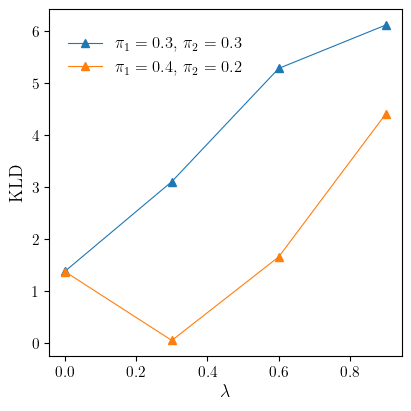

In [66]:
latexFont(titlesize=11, ticklabelssize=11, labelsize=13, legendsize=12)
fig, ax = plt.subplots(1,1, figsize=(4,4), constrained_layout=True)

ax.set(xlabel='$\lambda$', ylabel='KLD')
lambs = [0.0, 0.3, 0.6, 0.9]
pi_pairs = [(30, 30), (40, 20)]
ppls = ['$\pi_1 = 0.3$, $\pi_2 = 0.3$', '$\pi_1 = 0.4$, $\pi_2 = 0.2$']


for pi_pair,ppl in zip(pi_pairs,ppls):
    ax.plot(lambs, kl_div_f2ref_dicc[pi_pair], label=ppl, marker='^', lw=0.8)

fig.legend(frameon=False, loc=(0.15,0.8))



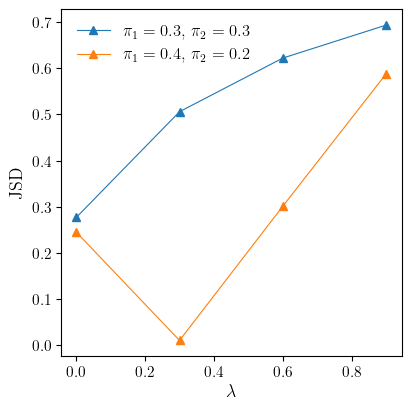

In [69]:
latexFont(titlesize=11, ticklabelssize=11, labelsize=13, legendsize=12)
fig, ax = plt.subplots(1,1, figsize=(4,4), constrained_layout=True)

ax.set(xlabel='$\lambda$', ylabel='JSD')
lambs = [0.0, 0.3, 0.6, 0.9]
pi_pairs = [(30, 30), (40, 20)]
ppls = ['$\pi_1 = 0.3$, $\pi_2 = 0.3$', '$\pi_1 = 0.4$, $\pi_2 = 0.2$']


for pi_pair,ppl in zip(pi_pairs,ppls):
    ax.plot(lambs, js_div_dicc[pi_pair], label=ppl, marker='^', lw=0.8)

fig.legend(frameon=False, loc=(0.17,0.83))

fig.savefig('jensen_shannon_div_fig2_histograms.pdf')